In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

### We check whether we train with GPU

In [2]:
print(torch.cuda.is_available())

True


### Defining transformations
These transformations are identical to the ones performed on the resnet50 and vgg

In [3]:
# Define transforms for the data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

### Defining constansts for the training model
These constast are identical to the ones in resnet50 and vgg models that are in comparison.

In [4]:
EPOCH_COUNT = 50
TO_RECOGNIZE = 5

TRAIN_PART = 0.8
LEARNING_RATE = 1e-3
PATIENCE = 12

CHECKPOINT_FILENAME = "checkpoint.tar"

In [5]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Preparing dataset:
I am using the datasets.ImageFolder method provided by torchvision to create a dataset. It creates a dataset from a folder structure where each class has its own directory containing the images belonging to the class

In [6]:
# Define the data directory
data_dir = 'Larger'  # Update this path as needed

# Load the full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=None)
CLASS_LIST = full_dataset.classes

# Split the dataset into train and test sets (80% train, 20% test)
train_idx, test_idx = train_test_split(
    list(range(len(full_dataset))), test_size=0.2, stratify=full_dataset.targets)

# Create subsets for each set
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

# Apply appropriate transforms to each subset
train_dataset.dataset.transform = data_transforms['train']
test_dataset.dataset.transform = data_transforms['test']

# Create dataloaders for each set
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Get dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

### Printing meta information about the dataset

In [7]:
# Define the method to print dataset information
def print_dataset_info(full_dataset, train_dataset, test_dataset):
    num_classes = len(full_dataset.classes)
    print(f"Total number of samples in the full dataset: {len(full_dataset)}")
    print(f"Number of samples in the training set: {len(train_dataset)}")
    print(f"Number of samples in the test set: {len(test_dataset)}")
    print(f"Total number of classes: {num_classes}")

# Print dataset information
print_dataset_info(full_dataset, train_dataset, test_dataset)

Total number of samples in the full dataset: 6812
Number of samples in the training set: 5449
Number of samples in the test set: 1363
Total number of classes: 4


In [8]:
# Get class names
class_names = full_dataset.classes
print(class_names)

['Coccidiosis', 'Healthy', 'Newcastle', 'Salmonella']


### Defining an early stopping method:

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

## Showcasing an array of images and their labels

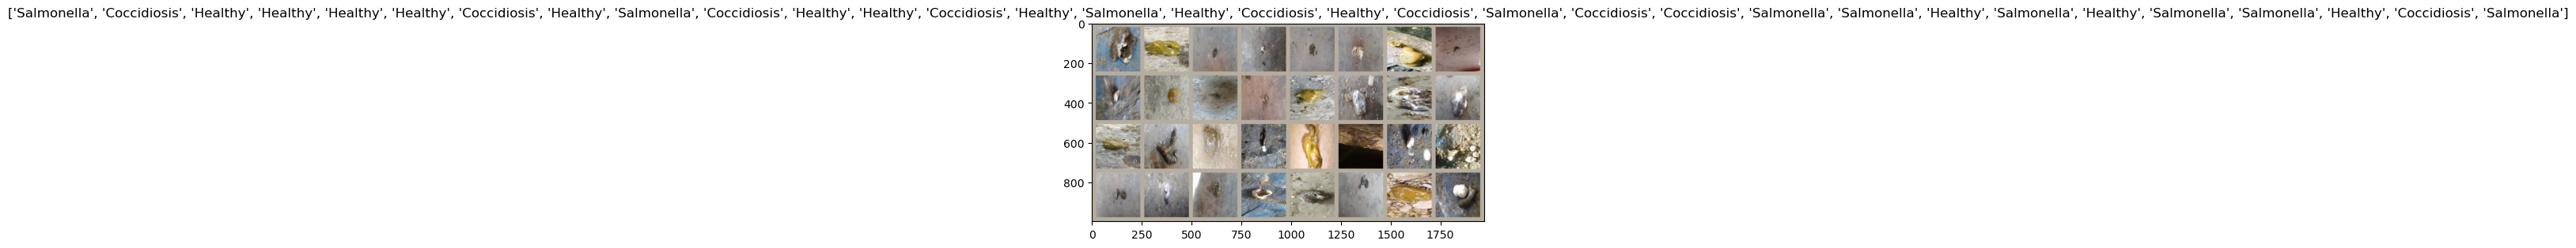

In [10]:
# Define a function to show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch with larger padding and bigger images
out = torchvision.utils.make_grid(inputs, padding=20, pad_value=1, scale_each=True)

# Display batch with labels
imshow(out, title=[class_names[x] for x in classes])
plt.show()


### Defining the training epoch function:

In [11]:
from tqdm import tqdm

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_train_loss = np.array([], dtype=np.float32)
    correct_predictions = 0
    total_predictions = 0

    # Wrap the train_loader with tqdm
    train_loader = tqdm(train_loader, desc="Training Batches")
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        running_train_loss = np.append(running_train_loss, loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, axis=1)

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    train_loss = np.mean(running_train_loss)
    train_accuracy = correct_predictions / total_predictions

    return train_loss, train_accuracy


### Calculation of metrics for all the predictions

In [12]:
def calculate_metrics(correct_predictions, total_predictions, y_true, y_pred):
    print('Total predictions: ', total_predictions)
    print('Correct predictions: ', correct_predictions)

    accuracy = correct_predictions / total_predictions
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, conf_matrix

### Calculation of metrics for each of the class with selected treshold

In [13]:
def calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.8):
    if len(all_true_labels.shape) == 1:
        all_true_labels = all_true_labels[:, None]

    num_classes = all_true_labels.shape[1]
    stats = {}
    for class_index in range(num_classes):
        predictions = (all_confidences[:, class_index] >= threshold).astype(int)
        true_labels = all_true_labels[:, class_index].astype(int)

        TP = np.sum((predictions == 1) & (true_labels == 1))
        TN = np.sum((predictions == 0) & (true_labels == 0))
        FP = np.sum((predictions == 1) & (true_labels == 0))
        FN = np.sum((predictions == 0) & (true_labels == 1))

        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        stats[class_index] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

    return stats

In [14]:
def evaluate_epoch(model, test_loader, criterion):
    model.eval()
    running_val_loss = np.array([], dtype=np.float32)
    correct_predictions, total_predictions = 0, 0
    y_true, y_pred, all_confidences, all_true_labels = [], [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            confidences = torch.sigmoid(outputs)
            val_loss = criterion(outputs, labels)
            running_val_loss = np.append(running_val_loss, val_loss.cpu().detach().numpy())

            predicted = torch.argmax(outputs, axis=1)

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            all_confidences.extend(confidences.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    all_confidences = np.array(all_confidences)
    all_true_labels = np.array(all_true_labels)
    
    stats = calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.8)

    for class_index, class_stats in stats.items():
        print(f"Class {class_index}:")
        print(f" Accuracy: {class_stats['accuracy']}")
        print(f" Precision: {class_stats['precision']}")
        print(f" Recall: {class_stats['recall']}")
        print(f" F1 Score: {class_stats['f1_score']}")

    return np.mean(running_val_loss), correct_predictions, total_predictions, y_true, y_pred, stats


In [15]:
def load_checkpoint(filename, model, optimizer):
    print("Loading checkpoint...")
    checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    training_history = {
        "epoch": checkpoint.get("epoch", 0),
        "train_loss_history": checkpoint.get("train_loss_history", []),
        "accuracy_history": checkpoint.get("accuracy_history", []),
        "train_accuracy_history": checkpoint.get("train_accuracy_history", []),
        "val_loss_history": checkpoint.get("val_loss_history", []),
        "precision_history": checkpoint.get("precision_history", []),
        "recall_history": checkpoint.get("recall_history", []),
        "f1_score_history": checkpoint.get("f1_score_history", []),
        "stats_history": checkpoint.get("stats_history", []),
        "conf_matrix": checkpoint.get("conf_matrix", [])
    }

    return training_history

def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

### Loading and finetuning model

In [16]:
# Load a pretrained MobileNetV2 model
model_ft = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of classes
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Move the model to the appropriate device
model_ft = model_ft.to(device)

c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
from datetime import datetime

LOAD_CHECKPOINT = False

def train_and_eval(model, loader_train, loader_valid, filename, epoch_count, lr):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model_ft.features.parameters(), 'lr': lr * 0.1},
        {'params': model_ft.classifier.parameters(), 'lr': lr}
    ])
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=PATIENCE, verbose=True)

    training_history = None

    if LOAD_CHECKPOINT:
        training_history = load_checkpoint(filename, model, optimizer)
        start_epoch = training_history['epoch'] + 1
        train_loss_history = training_history['train_loss_history']
        accuracy_history = training_history['accuracy_history']
        train_accuracy_history = training_history['train_accuracy_history']
        val_loss_history = training_history['val_loss_history']
        precision_history = training_history['precision_history']
        recall_history = training_history['recall_history']
        f1_score_history = training_history['f1_score_history']
        stats_history = training_history['stats_history']
        conf_matrix = training_history['conf_matrix']
    else:
        start_epoch = 0
        train_loss_history = []
        val_loss_history = []
        accuracy_history = []
        train_accuracy_history = []
        precision_history = []
        recall_history = []
        f1_score_history = []
        stats_history = []
        conf_matrix = []

    for epoch in range(start_epoch, epoch_count):
        print('Starting training epoch... ', epoch)
        start_time = datetime.now()

        train_loss, train_accuracy = train_epoch(model, loader_train, loss_func, optimizer)

        current_time = datetime.now()
        elapsed = seconds_to_time((current_time - start_time).total_seconds())
        print(f'Epoch: {epoch}, Time: {elapsed}, Loss: {train_loss}')

        print('Starting evaluation... ', start_time)
        start_time = datetime.now()

        avg_val_loss, correct_predictions, total_predictions, y_true, y_pred, stats = evaluate_epoch(model, dataloaders["test"], loss_func)

        accuracy, precision, recall, f1, conf_matrix = calculate_metrics(correct_predictions, total_predictions, y_true, y_pred)

        current_time = datetime.now()
        per_image = (current_time - start_time).total_seconds() / total_predictions
        print(f'Time: {per_image * 1000}ms, Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}')
        print(f'Confusion matrix: {conf_matrix}')

        accuracy_history.append(accuracy)
        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(train_loss)
        val_loss_history.append(avg_val_loss)
        precision_history.append(precision)
        recall_history.append(recall)
        f1_score_history.append(f1)
        stats_history.append(stats)

        print("Saving checkpoint...")
        checkpoint = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "train_loss_history": train_loss_history,
            "accuracy_history": accuracy_history,
            "train_accuracy_history": train_accuracy_history,
            "val_loss_history": val_loss_history,
            "precision_history": precision_history,
            "recall_history": recall_history,
            "f1_score_history": f1_score_history,
            "stats_history": stats_history,
            "conf_matrix": conf_matrix
        }
        torch.save(checkpoint, filename)

        scheduler.step(avg_val_loss)

        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Reducing learning rate and resetting early stopping.")
            early_stopping.counter = 0

    return training_history

### Teaching of the model

In [18]:
print(f'Parameter count: {sum(p.numel() for p in model_ft.parameters() if p.requires_grad):,}')
training_history = train_and_eval(model_ft, dataloaders["train"], dataloaders["test"], CHECKPOINT_FILENAME, epoch_count = EPOCH_COUNT, lr = LEARNING_RATE)

c:\Users\Lukas\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Parameter count: 2,228,996
Starting training epoch...  0


Training Batches: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]


Epoch: 0, Time: 1m27s, Loss: 0.17980484664440155
Starting evaluation...  2024-05-18 23:48:03.742528
Class 0:
 Accuracy: 0.006002400960384154
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1330
Time: 22.020117388114453ms, Epoch 0, Train Loss: 0.1798, Val Loss: 0.0557, Accuracy: 0.9758, Precision: 0.9758, Recall: 0.9758, F1 score: 0.9758
Confusion matrix: [[416   0   3   2]
 [  0 401   3   8]
 [  2   1  69   3]
 [  1  10   0 444]]
Saving checkpoint...
Starting training epoch...  1


Training Batches: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]


Epoch: 1, Time: 1m27s, Loss: 0.04718784987926483
Starting evaluation...  2024-05-18 23:50:01.554207
Class 0:
 Accuracy: 0.004801920768307323
 Precision: 0.002386634844868735
 Recall: 0.0024271844660194173
 F1 Score: 0.0024067388688327313
Total predictions:  1363
Correct predictions:  1341
Time: 21.699812179016877ms, Epoch 1, Train Loss: 0.0472, Val Loss: 0.0454, Accuracy: 0.9839, Precision: 0.9839, Recall: 0.9839, F1 score: 0.9838
Confusion matrix: [[419   0   0   2]
 [  0 405   1   6]
 [  2   2  70   1]
 [  0   8   0 447]]
Saving checkpoint...
Starting training epoch...  2


Training Batches: 100%|██████████| 171/171 [01:29<00:00,  1.91it/s]


Epoch: 2, Time: 1m29s, Loss: 0.03066403605043888
Starting evaluation...  2024-05-18 23:51:59.037110
Class 0:
 Accuracy: 0.004801920768307323
 Precision: 0.002386634844868735
 Recall: 0.0024271844660194173
 F1 Score: 0.0024067388688327313
Total predictions:  1363
Correct predictions:  1331
Time: 22.3138899486427ms, Epoch 2, Train Loss: 0.0307, Val Loss: 0.0722, Accuracy: 0.9765, Precision: 0.9771, Recall: 0.9765, F1 score: 0.9760
Confusion matrix: [[419   1   0   1]
 [  1 411   0   0]
 [  3   8  60   4]
 [  4  10   0 441]]
Saving checkpoint...
Starting training epoch...  3


Training Batches: 100%|██████████| 171/171 [01:33<00:00,  1.84it/s]


Epoch: 3, Time: 1m33s, Loss: 0.02975987084209919
Starting evaluation...  2024-05-18 23:53:59.250218
Class 0:
 Accuracy: 0.004801920768307323
 Precision: 0.002386634844868735
 Recall: 0.0024271844660194173
 F1 Score: 0.0024067388688327313
Total predictions:  1363
Correct predictions:  1337
Time: 22.23243213499633ms, Epoch 3, Train Loss: 0.0298, Val Loss: 0.0498, Accuracy: 0.9809, Precision: 0.9810, Recall: 0.9809, F1 score: 0.9807
Confusion matrix: [[419   1   0   1]
 [  0 406   1   5]
 [  3   5  65   2]
 [  3   5   0 447]]
Saving checkpoint...
Starting training epoch...  4


Training Batches: 100%|██████████| 171/171 [01:27<00:00,  1.96it/s]


Epoch: 4, Time: 1m27s, Loss: 0.01902797818183899
Starting evaluation...  2024-05-18 23:56:02.810003
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.002380952380952381
 Recall: 0.0024271844660194173
 F1 Score: 0.002403846153846154
Total predictions:  1363
Correct predictions:  1331
Time: 21.92234409391049ms, Epoch 4, Train Loss: 0.0190, Val Loss: 0.0662, Accuracy: 0.9765, Precision: 0.9768, Recall: 0.9765, F1 score: 0.9760
Confusion matrix: [[420   0   0   1]
 [  1 405   0   6]
 [  7   5  60   3]
 [  2   7   0 446]]
Saving checkpoint...
Starting training epoch...  5


Training Batches: 100%|██████████| 171/171 [01:30<00:00,  1.88it/s]


Epoch: 5, Time: 1m30s, Loss: 0.017791390419006348
Starting evaluation...  2024-05-18 23:58:00.195971
Class 0:
 Accuracy: 0.007202881152460984
 Precision: 0.002398081534772182
 Recall: 0.0024271844660194173
 F1 Score: 0.0024125452352231603
Total predictions:  1363
Correct predictions:  1338
Time: 22.521143800440203ms, Epoch 5, Train Loss: 0.0178, Val Loss: 0.0563, Accuracy: 0.9817, Precision: 0.9820, Recall: 0.9817, F1 score: 0.9817
Confusion matrix: [[417   2   1   1]
 [  0 410   1   1]
 [  0   1  73   1]
 [  2  13   2 438]]
Saving checkpoint...
Starting training epoch...  6


Training Batches: 100%|██████████| 171/171 [01:30<00:00,  1.89it/s]


Epoch: 6, Time: 1m30s, Loss: 0.013249674811959267
Starting evaluation...  2024-05-19 00:00:01.920140
Class 0:
 Accuracy: 0.006002400960384154
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1342
Time: 22.2821914893617ms, Epoch 6, Train Loss: 0.0132, Val Loss: 0.0517, Accuracy: 0.9846, Precision: 0.9847, Recall: 0.9846, F1 score: 0.9846
Confusion matrix: [[419   1   1   0]
 [  0 404   2   6]
 [  0   1  73   1]
 [  0   7   2 446]]
Saving checkpoint...
Starting training epoch...  7


Training Batches: 100%|██████████| 171/171 [01:28<00:00,  1.93it/s]


Epoch: 7, Time: 1m28s, Loss: 0.02393464371562004
Starting evaluation...  2024-05-19 00:02:02.753493
Class 0:
 Accuracy: 0.007202881152460984
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1335
Time: 23.134851063829785ms, Epoch 7, Train Loss: 0.0239, Val Loss: 0.0592, Accuracy: 0.9795, Precision: 0.9797, Recall: 0.9795, F1 score: 0.9795
Confusion matrix: [[417   2   1   1]
 [  0 401   1  10]
 [  1   1  73   0]
 [  2   4   5 444]]
Saving checkpoint...
Starting training epoch...  8


Training Batches: 100%|██████████| 171/171 [01:30<00:00,  1.88it/s]


Epoch: 8, Time: 1m30s, Loss: 0.018540898337960243
Starting evaluation...  2024-05-19 00:04:02.910934
Class 0:
 Accuracy: 0.004801920768307323
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 23.730395451210565ms, Epoch 8, Train Loss: 0.0185, Val Loss: 0.0335, Accuracy: 0.9912, Precision: 0.9913, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[419   2   0   0]
 [  0 411   0   1]
 [  1   1  73   0]
 [  0   6   1 448]]
Saving checkpoint...
Starting training epoch...  9


Training Batches: 100%|██████████| 171/171 [01:33<00:00,  1.83it/s]


Epoch: 9, Time: 1m33s, Loss: 0.0037912321276962757
Starting evaluation...  2024-05-19 00:06:06.407164
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1347
Time: 22.871701393983862ms, Epoch 9, Train Loss: 0.0038, Val Loss: 0.0389, Accuracy: 0.9883, Precision: 0.9883, Recall: 0.9883, F1 score: 0.9883
Confusion matrix: [[420   1   0   0]
 [  0 406   3   3]
 [  1   1  72   1]
 [  0   6   0 449]]
Saving checkpoint...
Starting training epoch...  10


Training Batches: 100%|██████████| 171/171 [01:30<00:00,  1.90it/s]


Epoch: 10, Time: 1m30s, Loss: 0.008963894098997116
Starting evaluation...  2024-05-19 00:08:11.141459
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1341
Time: 22.031221570066034ms, Epoch 10, Train Loss: 0.0090, Val Loss: 0.0623, Accuracy: 0.9839, Precision: 0.9841, Recall: 0.9839, F1 score: 0.9839
Confusion matrix: [[420   0   0   1]
 [  0 409   1   2]
 [  0   4  70   1]
 [  0  12   1 442]]
Saving checkpoint...
Starting training epoch...  11


Training Batches: 100%|██████████| 171/171 [01:30<00:00,  1.89it/s]


Epoch: 11, Time: 1m30s, Loss: 0.023875776678323746
Starting evaluation...  2024-05-19 00:10:11.483554
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1341
Time: 22.40037417461482ms, Epoch 11, Train Loss: 0.0239, Val Loss: 0.0591, Accuracy: 0.9839, Precision: 0.9840, Recall: 0.9839, F1 score: 0.9839
Confusion matrix: [[417   0   2   2]
 [  0 401   2   9]
 [  0   2  72   1]
 [  0   4   0 451]]
Saving checkpoint...
Starting training epoch...  12


Training Batches: 100%|██████████| 171/171 [01:34<00:00,  1.81it/s]


Epoch: 12, Time: 1m34s, Loss: 0.022021956741809845
Starting evaluation...  2024-05-19 00:12:12.699494
Class 0:
 Accuracy: 0.006002400960384154
 Precision: 0.009433962264150943
 Recall: 0.009708737864077669
 F1 Score: 0.00956937799043062
Total predictions:  1363
Correct predictions:  1348
Time: 23.340949376375644ms, Epoch 12, Train Loss: 0.0220, Val Loss: 0.0455, Accuracy: 0.9890, Precision: 0.9890, Recall: 0.9890, F1 score: 0.9890
Confusion matrix: [[419   0   1   1]
 [  0 407   2   3]
 [  1   1  72   1]
 [  1   3   1 450]]
Saving checkpoint...
Starting training epoch...  13


Training Batches: 100%|██████████| 171/171 [01:35<00:00,  1.80it/s]


Epoch: 13, Time: 1m35s, Loss: 0.008223140612244606
Starting evaluation...  2024-05-19 00:14:19.188098
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1350
Time: 23.611208363903156ms, Epoch 13, Train Loss: 0.0082, Val Loss: 0.0315, Accuracy: 0.9905, Precision: 0.9905, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[421   0   0   0]
 [  0 408   2   2]
 [  0   1  73   1]
 [  1   5   1 448]]
Saving checkpoint...
Starting training epoch...  14


Training Batches: 100%|██████████| 171/171 [01:34<00:00,  1.81it/s]


Epoch: 14, Time: 1m34s, Loss: 0.00826960802078247
Starting evaluation...  2024-05-19 00:16:26.774345
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1350
Time: 23.574177549523114ms, Epoch 14, Train Loss: 0.0083, Val Loss: 0.0341, Accuracy: 0.9905, Precision: 0.9905, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[421   0   0   0]
 [  0 408   1   3]
 [  0   2  73   0]
 [  1   5   1 448]]
Saving checkpoint...
Starting training epoch...  15


Training Batches: 100%|██████████| 171/171 [01:35<00:00,  1.80it/s]


Epoch: 15, Time: 1m35s, Loss: 0.016549276188015938
Starting evaluation...  2024-05-19 00:18:33.695771
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 23.442687454145272ms, Epoch 15, Train Loss: 0.0165, Val Loss: 0.0332, Accuracy: 0.9912, Precision: 0.9912, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[421   0   0   0]
 [  0 405   1   6]
 [  0   1  74   0]
 [  0   4   0 451]]
Saving checkpoint...
Starting training epoch...  16


Training Batches: 100%|██████████| 171/171 [01:35<00:00,  1.78it/s]


Epoch: 16, Time: 1m35s, Loss: 0.02884749136865139
Starting evaluation...  2024-05-19 00:20:40.955089
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1350
Time: 23.08019295671313ms, Epoch 16, Train Loss: 0.0288, Val Loss: 0.0352, Accuracy: 0.9905, Precision: 0.9905, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[420   0   0   1]
 [  0 406   1   5]
 [  0   1  74   0]
 [  0   3   2 450]]
Saving checkpoint...
Starting training epoch...  17


Training Batches: 100%|██████████| 171/171 [01:36<00:00,  1.77it/s]


Epoch: 17, Time: 1m36s, Loss: 0.009208131581544876
Starting evaluation...  2024-05-19 00:22:48.460866
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1345
Time: 23.6087417461482ms, Epoch 17, Train Loss: 0.0092, Val Loss: 0.0407, Accuracy: 0.9868, Precision: 0.9868, Recall: 0.9868, F1 score: 0.9868
Confusion matrix: [[420   0   0   1]
 [  0 404   1   7]
 [  1   2  72   0]
 [  0   5   1 449]]
Saving checkpoint...
Starting training epoch...  18


Training Batches: 100%|██████████| 171/171 [01:36<00:00,  1.77it/s]


Epoch: 18, Time: 1m36s, Loss: 0.027618257328867912
Starting evaluation...  2024-05-19 00:24:57.366708
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1332
Time: 23.64147028613353ms, Epoch 18, Train Loss: 0.0276, Val Loss: 0.0590, Accuracy: 0.9773, Precision: 0.9778, Recall: 0.9773, F1 score: 0.9769
Confusion matrix: [[416   4   0   1]
 [  0 406   0   6]
 [  1  10  61   3]
 [  0   6   0 449]]
Saving checkpoint...
Starting training epoch...  19


Training Batches: 100%|██████████| 171/171 [01:37<00:00,  1.76it/s]


Epoch: 19, Time: 1m37s, Loss: 0.005655593704432249
Starting evaluation...  2024-05-19 00:27:06.442491
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1350
Time: 23.78406162876009ms, Epoch 19, Train Loss: 0.0057, Val Loss: 0.0298, Accuracy: 0.9905, Precision: 0.9905, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[419   0   0   2]
 [  0 410   0   2]
 [  0   2  72   1]
 [  0   6   0 449]]
Saving checkpoint...
Starting training epoch...  20


Training Batches: 100%|██████████| 171/171 [01:33<00:00,  1.82it/s]


Epoch: 20, Time: 1m33s, Loss: 0.004929926712065935
Starting evaluation...  2024-05-19 00:29:16.234501
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1348
Time: 23.564285399853265ms, Epoch 20, Train Loss: 0.0049, Val Loss: 0.0499, Accuracy: 0.9890, Precision: 0.9892, Recall: 0.9890, F1 score: 0.9890
Confusion matrix: [[420   1   0   0]
 [  0 411   0   1]
 [  1   2  72   0]
 [  0   9   1 445]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  21


Training Batches: 100%|██████████| 171/171 [01:34<00:00,  1.81it/s]


Epoch: 21, Time: 1m34s, Loss: 0.010057506151497364
Starting evaluation...  2024-05-19 00:31:22.434150
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1344
Time: 24.10901393983859ms, Epoch 21, Train Loss: 0.0101, Val Loss: 0.0563, Accuracy: 0.9861, Precision: 0.9862, Recall: 0.9861, F1 score: 0.9861
Confusion matrix: [[419   1   1   0]
 [  0 409   0   3]
 [  1   3  71   0]
 [  1   8   1 445]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  22


Training Batches: 100%|██████████| 171/171 [01:35<00:00,  1.79it/s]


Epoch: 22, Time: 1m35s, Loss: 0.006395348813384771
Starting evaluation...  2024-05-19 00:33:29.847791
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1341
Time: 23.34702347762289ms, Epoch 22, Train Loss: 0.0064, Val Loss: 0.0626, Accuracy: 0.9839, Precision: 0.9839, Recall: 0.9839, F1 score: 0.9837
Confusion matrix: [[421   0   0   0]
 [  0 405   0   7]
 [  4   3  67   1]
 [  1   6   0 448]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  23


Training Batches: 100%|██████████| 171/171 [01:34<00:00,  1.81it/s]


Epoch: 23, Time: 1m34s, Loss: 0.020317548885941505
Starting evaluation...  2024-05-19 00:35:37.544479
Class 0:
 Accuracy: 0.006002400960384154
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1335
Time: 23.05523771093177ms, Epoch 23, Train Loss: 0.0203, Val Loss: 0.0799, Accuracy: 0.9795, Precision: 0.9807, Recall: 0.9795, F1 score: 0.9798
Confusion matrix: [[416   0   3   2]
 [  0 408   3   1]
 [  0   1  73   1]
 [  0  10   7 438]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  24


Training Batches: 100%|██████████| 171/171 [01:34<00:00,  1.80it/s]


Epoch: 24, Time: 1m34s, Loss: 0.04578940197825432
Starting evaluation...  2024-05-19 00:37:43.610952
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1344
Time: 23.33306309611152ms, Epoch 24, Train Loss: 0.0458, Val Loss: 0.0406, Accuracy: 0.9861, Precision: 0.9863, Recall: 0.9861, F1 score: 0.9861
Confusion matrix: [[419   1   1   0]
 [  0 411   0   1]
 [  0   4  71   0]
 [  2   9   1 443]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  25


Training Batches: 100%|██████████| 171/171 [01:33<00:00,  1.84it/s]


Epoch: 25, Time: 1m33s, Loss: 0.007866672240197659
Starting evaluation...  2024-05-19 00:39:50.531747
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1348
Time: 23.00527219369039ms, Epoch 25, Train Loss: 0.0079, Val Loss: 0.0402, Accuracy: 0.9890, Precision: 0.9891, Recall: 0.9890, F1 score: 0.9890
Confusion matrix: [[418   1   1   1]
 [  0 412   0   0]
 [  0   4  70   1]
 [  1   5   1 448]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  26


Training Batches: 100%|██████████| 171/171 [01:32<00:00,  1.84it/s]


Epoch: 26, Time: 1m32s, Loss: 0.007496427278965712
Starting evaluation...  2024-05-19 00:41:55.210292
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1347
Time: 22.918571533382245ms, Epoch 26, Train Loss: 0.0075, Val Loss: 0.0432, Accuracy: 0.9883, Precision: 0.9885, Recall: 0.9883, F1 score: 0.9882
Confusion matrix: [[421   0   0   0]
 [  0 412   0   0]
 [  0   1  74   0]
 [  5   7   3 440]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  27


Training Batches: 100%|██████████| 171/171 [01:33<00:00,  1.83it/s]


Epoch: 27, Time: 1m33s, Loss: 0.009893740527331829
Starting evaluation...  2024-05-19 00:43:59.559460
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.004728132387706856
 Recall: 0.0048543689320388345
 F1 Score: 0.004790419161676647
Total predictions:  1363
Correct predictions:  1343
Time: 23.169160674981658ms, Epoch 27, Train Loss: 0.0099, Val Loss: 0.0534, Accuracy: 0.9853, Precision: 0.9854, Recall: 0.9853, F1 score: 0.9853
Confusion matrix: [[421   0   0   0]
 [  1 406   1   4]
 [  0   2  72   1]
 [  2   6   3 444]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  28


Training Batches: 100%|██████████| 171/171 [01:34<00:00,  1.81it/s]


Epoch: 28, Time: 1m34s, Loss: 0.018431754782795906
Starting evaluation...  2024-05-19 00:46:04.931365
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1343
Time: 23.173928833455612ms, Epoch 28, Train Loss: 0.0184, Val Loss: 0.0521, Accuracy: 0.9853, Precision: 0.9856, Recall: 0.9853, F1 score: 0.9853
Confusion matrix: [[418   3   0   0]
 [  0 411   0   1]
 [  0   5  69   1]
 [  0   8   2 445]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  29


Training Batches: 100%|██████████| 171/171 [01:31<00:00,  1.87it/s]


Epoch: 29, Time: 1m31s, Loss: 0.016144054010510445
Starting evaluation...  2024-05-19 00:48:11.064553
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1349
Time: 23.060001467351434ms, Epoch 29, Train Loss: 0.0161, Val Loss: 0.0342, Accuracy: 0.9897, Precision: 0.9900, Recall: 0.9897, F1 score: 0.9898
Confusion matrix: [[419   2   0   0]
 [  0 410   1   1]
 [  0   1  74   0]
 [  0   5   4 446]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  30


Training Batches: 100%|██████████| 171/171 [01:26<00:00,  1.98it/s]


Epoch: 30, Time: 1m26s, Loss: 0.0017439932562410831
Starting evaluation...  2024-05-19 00:50:14.104182
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1350
Time: 21.93684299339692ms, Epoch 30, Train Loss: 0.0017, Val Loss: 0.0368, Accuracy: 0.9905, Precision: 0.9906, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[419   2   0   0]
 [  0 411   0   1]
 [  0   1  74   0]
 [  1   6   2 446]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  31


Training Batches: 100%|██████████| 171/171 [01:30<00:00,  1.88it/s]


Epoch: 31, Time: 1m30s, Loss: 0.0029029608704149723
Starting evaluation...  2024-05-19 00:52:10.675221
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1350
Time: 21.77224944974321ms, Epoch 31, Train Loss: 0.0029, Val Loss: 0.0381, Accuracy: 0.9905, Precision: 0.9906, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[419   2   0   0]
 [  0 411   1   0]
 [  0   2  72   1]
 [  0   6   1 448]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  32


Training Batches: 100%|██████████| 171/171 [01:29<00:00,  1.91it/s]


Epoch: 32, Time: 1m29s, Loss: 0.0011927211889997125
Starting evaluation...  2024-05-19 00:54:11.406111
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 21.78098606016141ms, Epoch 32, Train Loss: 0.0012, Val Loss: 0.0388, Accuracy: 0.9912, Precision: 0.9913, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[418   2   0   1]
 [  0 411   1   0]
 [  0   2  72   1]
 [  0   5   0 450]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  33


Training Batches: 100%|██████████| 171/171 [01:28<00:00,  1.94it/s]


Epoch: 33, Time: 1m28s, Loss: 0.019266663119196892
Starting evaluation...  2024-05-19 00:56:10.800250
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 22.077674981658106ms, Epoch 33, Train Loss: 0.0193, Val Loss: 0.0425, Accuracy: 0.9912, Precision: 0.9914, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[419   2   0   0]
 [  0 412   0   0]
 [  0   2  72   1]
 [  0   7   0 448]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  34


Training Batches: 100%|██████████| 171/171 [01:31<00:00,  1.86it/s]


Epoch: 34, Time: 1m31s, Loss: 0.0010310153011232615
Starting evaluation...  2024-05-19 00:58:09.287056
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1353
Time: 23.250503301540718ms, Epoch 34, Train Loss: 0.0010, Val Loss: 0.0411, Accuracy: 0.9927, Precision: 0.9928, Recall: 0.9927, F1 score: 0.9927
Confusion matrix: [[420   1   0   0]
 [  0 412   0   0]
 [  0   2  72   1]
 [  0   6   0 449]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  35


Training Batches: 100%|██████████| 171/171 [01:30<00:00,  1.89it/s]


Epoch: 35, Time: 1m30s, Loss: 0.0013345745392143726
Starting evaluation...  2024-05-19 01:00:12.923357
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1350
Time: 22.33038077769626ms, Epoch 35, Train Loss: 0.0013, Val Loss: 0.0428, Accuracy: 0.9905, Precision: 0.9906, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[419   2   0   0]
 [  0 411   1   0]
 [  0   1  73   1]
 [  0   8   0 447]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  36


Training Batches: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]


Epoch: 36, Time: 1m27s, Loss: 0.00021319025836419314
Starting evaluation...  2024-05-19 01:02:14.102954
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1348
Time: 21.64837857666911ms, Epoch 36, Train Loss: 0.0002, Val Loss: 0.0492, Accuracy: 0.9890, Precision: 0.9892, Recall: 0.9890, F1 score: 0.9890
Confusion matrix: [[419   2   0   0]
 [  0 411   1   0]
 [  0   2  72   1]
 [  0   9   0 446]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  37


Training Batches: 100%|██████████| 171/171 [01:26<00:00,  1.98it/s]


Epoch: 37, Time: 1m26s, Loss: 0.0006113788112998009
Starting evaluation...  2024-05-19 01:04:11.489264
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 21.661669112252383ms, Epoch 37, Train Loss: 0.0006, Val Loss: 0.0416, Accuracy: 0.9912, Precision: 0.9913, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[419   2   0   0]
 [  0 411   1   0]
 [  0   2  72   1]
 [  0   6   0 449]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  38


Training Batches: 100%|██████████| 171/171 [01:29<00:00,  1.92it/s]


Epoch: 38, Time: 1m29s, Loss: 0.0001366325159324333
Starting evaluation...  2024-05-19 01:06:07.799455
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 21.67293983859134ms, Epoch 38, Train Loss: 0.0001, Val Loss: 0.0448, Accuracy: 0.9912, Precision: 0.9913, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[419   2   0   0]
 [  0 411   1   0]
 [  0   1  73   1]
 [  0   7   0 448]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  39


Training Batches: 100%|██████████| 171/171 [01:26<00:00,  1.98it/s]


Epoch: 39, Time: 1m26s, Loss: 0.0002987413899973035
Starting evaluation...  2024-05-19 01:08:06.568168
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 20.90024578136464ms, Epoch 39, Train Loss: 0.0003, Val Loss: 0.0348, Accuracy: 0.9912, Precision: 0.9913, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[419   2   0   0]
 [  0 410   1   1]
 [  0   1  73   1]
 [  0   6   0 449]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  40


Training Batches: 100%|██████████| 171/171 [01:19<00:00,  2.15it/s]


Epoch: 40, Time: 1m19s, Loss: 0.00011277613521087915
Starting evaluation...  2024-05-19 01:10:01.404347
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1352
Time: 20.613948642699928ms, Epoch 40, Train Loss: 0.0001, Val Loss: 0.0391, Accuracy: 0.9919, Precision: 0.9920, Recall: 0.9919, F1 score: 0.9919
Confusion matrix: [[419   2   0   0]
 [  0 411   1   0]
 [  0   1  73   1]
 [  0   6   0 449]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  41


Training Batches: 100%|██████████| 171/171 [01:22<00:00,  2.06it/s]


Epoch: 41, Time: 1m22s, Loss: 0.00783564057201147
Starting evaluation...  2024-05-19 01:11:49.224195
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1350
Time: 20.812374908290536ms, Epoch 41, Train Loss: 0.0078, Val Loss: 0.0434, Accuracy: 0.9905, Precision: 0.9905, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[419   2   0   0]
 [  0 408   1   3]
 [  0   1  73   1]
 [  0   5   0 450]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  42


Training Batches: 100%|██████████| 171/171 [01:22<00:00,  2.06it/s]


Epoch: 42, Time: 1m22s, Loss: 0.0007392387487925589
Starting evaluation...  2024-05-19 01:13:40.658981
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1349
Time: 20.577493763756422ms, Epoch 42, Train Loss: 0.0007, Val Loss: 0.0395, Accuracy: 0.9897, Precision: 0.9898, Recall: 0.9897, F1 score: 0.9897
Confusion matrix: [[419   2   0   0]
 [  0 407   1   4]
 [  0   1  73   1]
 [  0   5   0 450]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  43


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.13it/s]


Epoch: 43, Time: 1m20s, Loss: 0.0004242388822603971
Starting evaluation...  2024-05-19 01:15:31.795179
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1345
Time: 20.251403521643436ms, Epoch 43, Train Loss: 0.0004, Val Loss: 0.0400, Accuracy: 0.9868, Precision: 0.9868, Recall: 0.9868, F1 score: 0.9868
Confusion matrix: [[419   2   0   0]
 [  0 403   1   8]
 [  0   1  73   1]
 [  0   5   0 450]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  44


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.13it/s]


Epoch: 44, Time: 1m20s, Loss: 0.0005431033787317574
Starting evaluation...  2024-05-19 01:17:20.050879
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1349
Time: 20.28307703595011ms, Epoch 44, Train Loss: 0.0005, Val Loss: 0.0395, Accuracy: 0.9897, Precision: 0.9898, Recall: 0.9897, F1 score: 0.9897
Confusion matrix: [[419   2   0   0]
 [  0 409   1   2]
 [  0   1  73   1]
 [  0   7   0 448]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  45


Training Batches: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]


Epoch: 45, Time: 1m27s, Loss: 0.00010730448411777616
Starting evaluation...  2024-05-19 01:19:08.284936
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 20.800766691122522ms, Epoch 45, Train Loss: 0.0001, Val Loss: 0.0426, Accuracy: 0.9912, Precision: 0.9913, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[419   2   0   0]
 [  0 411   0   1]
 [  0   2  72   1]
 [  0   6   0 449]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  46


Training Batches: 100%|██████████| 171/171 [01:23<00:00,  2.04it/s]


Epoch: 46, Time: 1m23s, Loss: 0.0001899892376968637
Starting evaluation...  2024-05-19 01:21:04.529068
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1349
Time: 20.622827586206895ms, Epoch 46, Train Loss: 0.0002, Val Loss: 0.0358, Accuracy: 0.9897, Precision: 0.9898, Recall: 0.9897, F1 score: 0.9897
Confusion matrix: [[419   2   0   0]
 [  0 409   1   2]
 [  0   1  73   1]
 [  0   7   0 448]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  47


Training Batches: 100%|██████████| 171/171 [01:25<00:00,  2.01it/s]


Epoch: 47, Time: 1m25s, Loss: 0.000999491778202355
Starting evaluation...  2024-05-19 01:22:56.583030
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 21.92982245047689ms, Epoch 47, Train Loss: 0.0010, Val Loss: 0.0382, Accuracy: 0.9912, Precision: 0.9913, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[419   2   0   0]
 [  0 410   0   2]
 [  0   1  73   1]
 [  0   6   0 449]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  48


Training Batches: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]


Epoch: 48, Time: 1m27s, Loss: 0.00011978217662544921
Starting evaluation...  2024-05-19 01:24:51.704045
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1348
Time: 22.20392002934703ms, Epoch 48, Train Loss: 0.0001, Val Loss: 0.0427, Accuracy: 0.9890, Precision: 0.9891, Recall: 0.9890, F1 score: 0.9890
Confusion matrix: [[419   2   0   0]
 [  0 409   1   2]
 [  0   2  72   1]
 [  0   7   0 448]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  49


Training Batches: 100%|██████████| 171/171 [01:28<00:00,  1.93it/s]


Epoch: 49, Time: 1m28s, Loss: 0.008526727557182312
Starting evaluation...  2024-05-19 01:26:49.925147
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1350
Time: 21.63378356566398ms, Epoch 49, Train Loss: 0.0085, Val Loss: 0.0352, Accuracy: 0.9905, Precision: 0.9905, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[419   2   0   0]
 [  0 408   1   3]
 [  0   1  73   1]
 [  0   5   0 450]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.


## Display of statistics

c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading checkpoint...


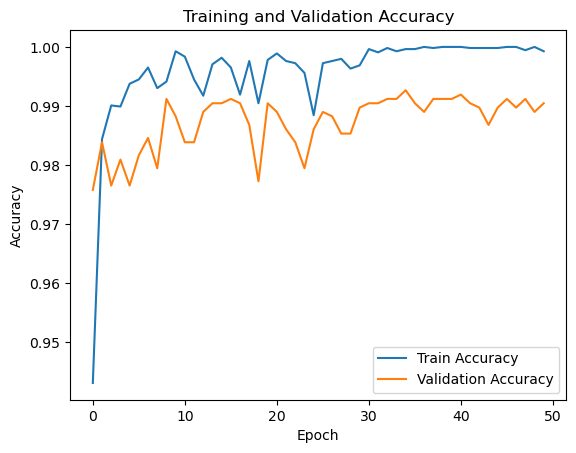

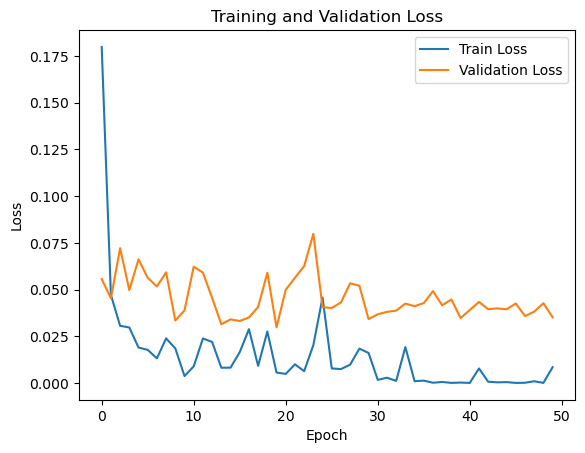

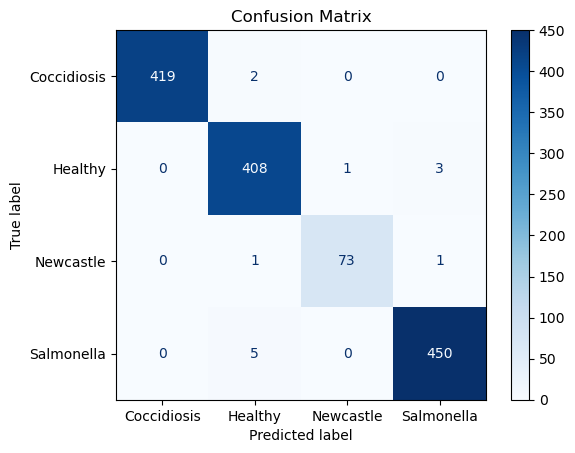

In [19]:
optimizer = optim.Adam([
        {'params': model_ft.features.parameters(), 'lr': LEARNING_RATE * 0.1},
        {'params': model_ft.classifier.parameters(), 'lr': LEARNING_RATE}
])

# Load a pretrained MobileNetV2 model
model_ft = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of classes
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Move the model to the appropriate device
model_ft = model_ft.to(device)

training_history = load_checkpoint(CHECKPOINT_FILENAME, model_ft, optimizer)

train_accuracy_history = training_history['train_accuracy_history']
accuracy_history = training_history['accuracy_history']
train_loss_history = training_history['train_loss_history']
val_loss_history = training_history['val_loss_history']
conf_matrix = training_history['conf_matrix']

plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

if isinstance(conf_matrix, list):
    last_conf_matrix = np.array(conf_matrix[-1])
else:
    last_conf_matrix = np.array(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=last_conf_matrix, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()